In [253]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

In [254]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz,  plot_tree
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [255]:
employee = pd.read_csv('employee_cleaned.csv')
employee.head()

,Education,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Duration
0,Bachelors,Bangalore,3,34,Male,No,0,0,3
1,Bachelors,Pune,1,28,Female,No,3,1,7
2,Bachelors,New Delhi,3,38,Female,No,2,0,6
3,Masters,Bangalore,3,27,Male,No,5,1,4
4,Masters,Pune,3,24,Male,Yes,2,1,3


In [256]:
#employee['Education'].replace({'PHD': 'a', 'Masters': 'b', 'Bachelors': 'c'}, inplace=True)
employee['Education'].replace(to_replace = ['PHD', 'Masters', 'Bachelors'], value = ['3', '2', '1'], inplace = True)
employee['Education'] = employee['Education'].astype('int64')
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  2764 non-null   int64 
 1   City                       2764 non-null   object
 2   PaymentTier                2764 non-null   int64 
 3   Age                        2764 non-null   int64 
 4   Gender                     2764 non-null   object
 5   EverBenched                2764 non-null   object
 6   ExperienceInCurrentDomain  2764 non-null   int64 
 7   LeaveOrNot                 2764 non-null   int64 
 8   Duration                   2764 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 194.5+ KB


## Split the data into training and test sets

In [257]:
employee_train, employee_test = train_test_split(employee, test_size = 0.40, random_state = 7)
print(employee.shape)
print(employee_train.shape)
print(employee_test.shape)

(2764, 9)
(1658, 9)
(1106, 9)


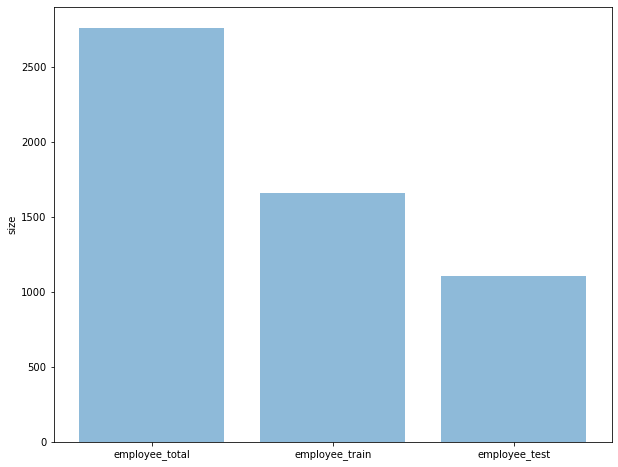

In [258]:
portion = ('employee_total', 'employee_train', 'employee_test')
y_pos = np.arange(len(portion))
size = [2764,1658,1106]

plt.bar(y_pos, size, align='center', alpha=0.5)
plt.xticks(y_pos, portion)
plt.ylabel('size')

plt.show()

### Separate data frames for interested predictor variables and response variable

### *Data with all predictor variables

In [259]:
#---Training set---

x_all = employee_train.drop(['LeaveOrNot'], axis= 1)
x_all = pd.get_dummies(x_all)
y_all = employee_train[['LeaveOrNot']]
y_names_all = ["No", "Yes"]

#---Test set---

x_test_all = employee_test.drop(['LeaveOrNot'], axis= 1)
x_test_all = pd.get_dummies(x_test_all)
y_test_all = employee_test[['LeaveOrNot']]

x_all.head(2)


,Education,PaymentTier,Age,ExperienceInCurrentDomain,Duration,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes
2040,1,3,33,5,3,0,0,1,0,1,0,1
1872,1,3,40,0,4,1,0,0,0,1,1,0


In [260]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import random

In [261]:
#Change response variable to one-dimension array 
rfy_all = np.ravel(y_all)

In [262]:
#The n_estimators= 100, criterion  = "gini" id default (don't have to specufy)--
#--set max_depth to limit the depth of the tree, or limit branches
#--Set random_state for reproducible results
rf_all = RandomForestClassifier(n_estimators = 100, \
                              criterion = "gini", max_depth=5, random_state = 42).fit(x_all,rfy_all)

y_train_pred_all = rf_all.predict(x_all)
y_train_pred_all 

array([0, 0, 0, ..., 0, 0, 0])

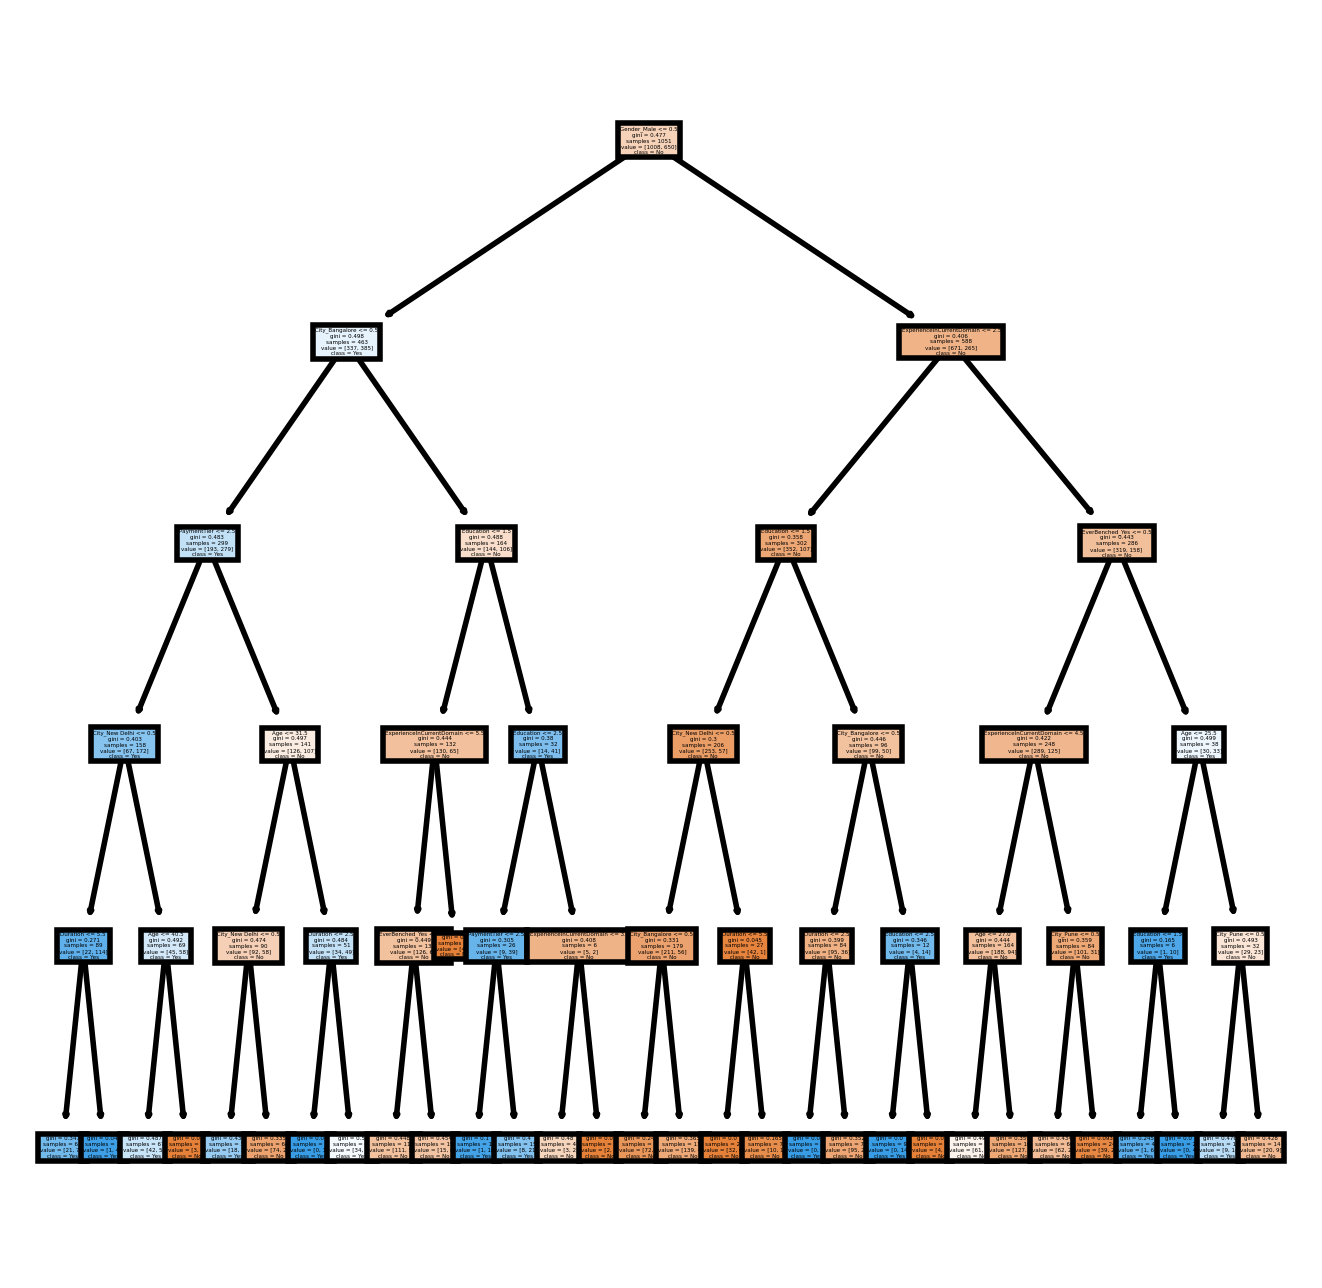

In [263]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=400)
#use .estimator[] to specify individual tree 
tree.plot_tree(rf_all.estimators_[0],
               feature_names = x_all.columns.values, 
               class_names=y_names_all,
               filled = True);
fig.savefig('rf_all_individualtree.png')

In [291]:
#Make prediction
y_pred_all = rf_all.predict(x_test_all)

#count number of predict for each class
unique, counts = np.unique(y_pred_all, return_counts=True)
dict(zip(unique, counts))

{0: 827, 1: 279}

In [265]:
print("Accuracy:",metrics.accuracy_score(y_test_all, y_pred_all))
print("Precision:",metrics.precision_score(y_test_all, y_pred_all))
print("Recall:",metrics.recall_score(y_test_all, y_pred_all))

Accuracy: 0.7603978300180831
Precision: 0.8422939068100358
Recall: 0.5153508771929824


In [266]:
#Feature importance
feature_scores_all = pd.Series(rf_all.feature_importances_, index= x_all.columns).sort_values(ascending=False)

feature_scores_all

Duration                     0.383466
PaymentTier                  0.113287
Education                    0.105719
City_Pune                    0.102087
Gender_Male                  0.081873
Gender_Female                0.065117
Age                          0.059224
City_Bangalore               0.030643
ExperienceInCurrentDomain    0.024142
City_New Delhi               0.016379
EverBenched_Yes              0.009856
EverBenched_No               0.008206
dtype: float64

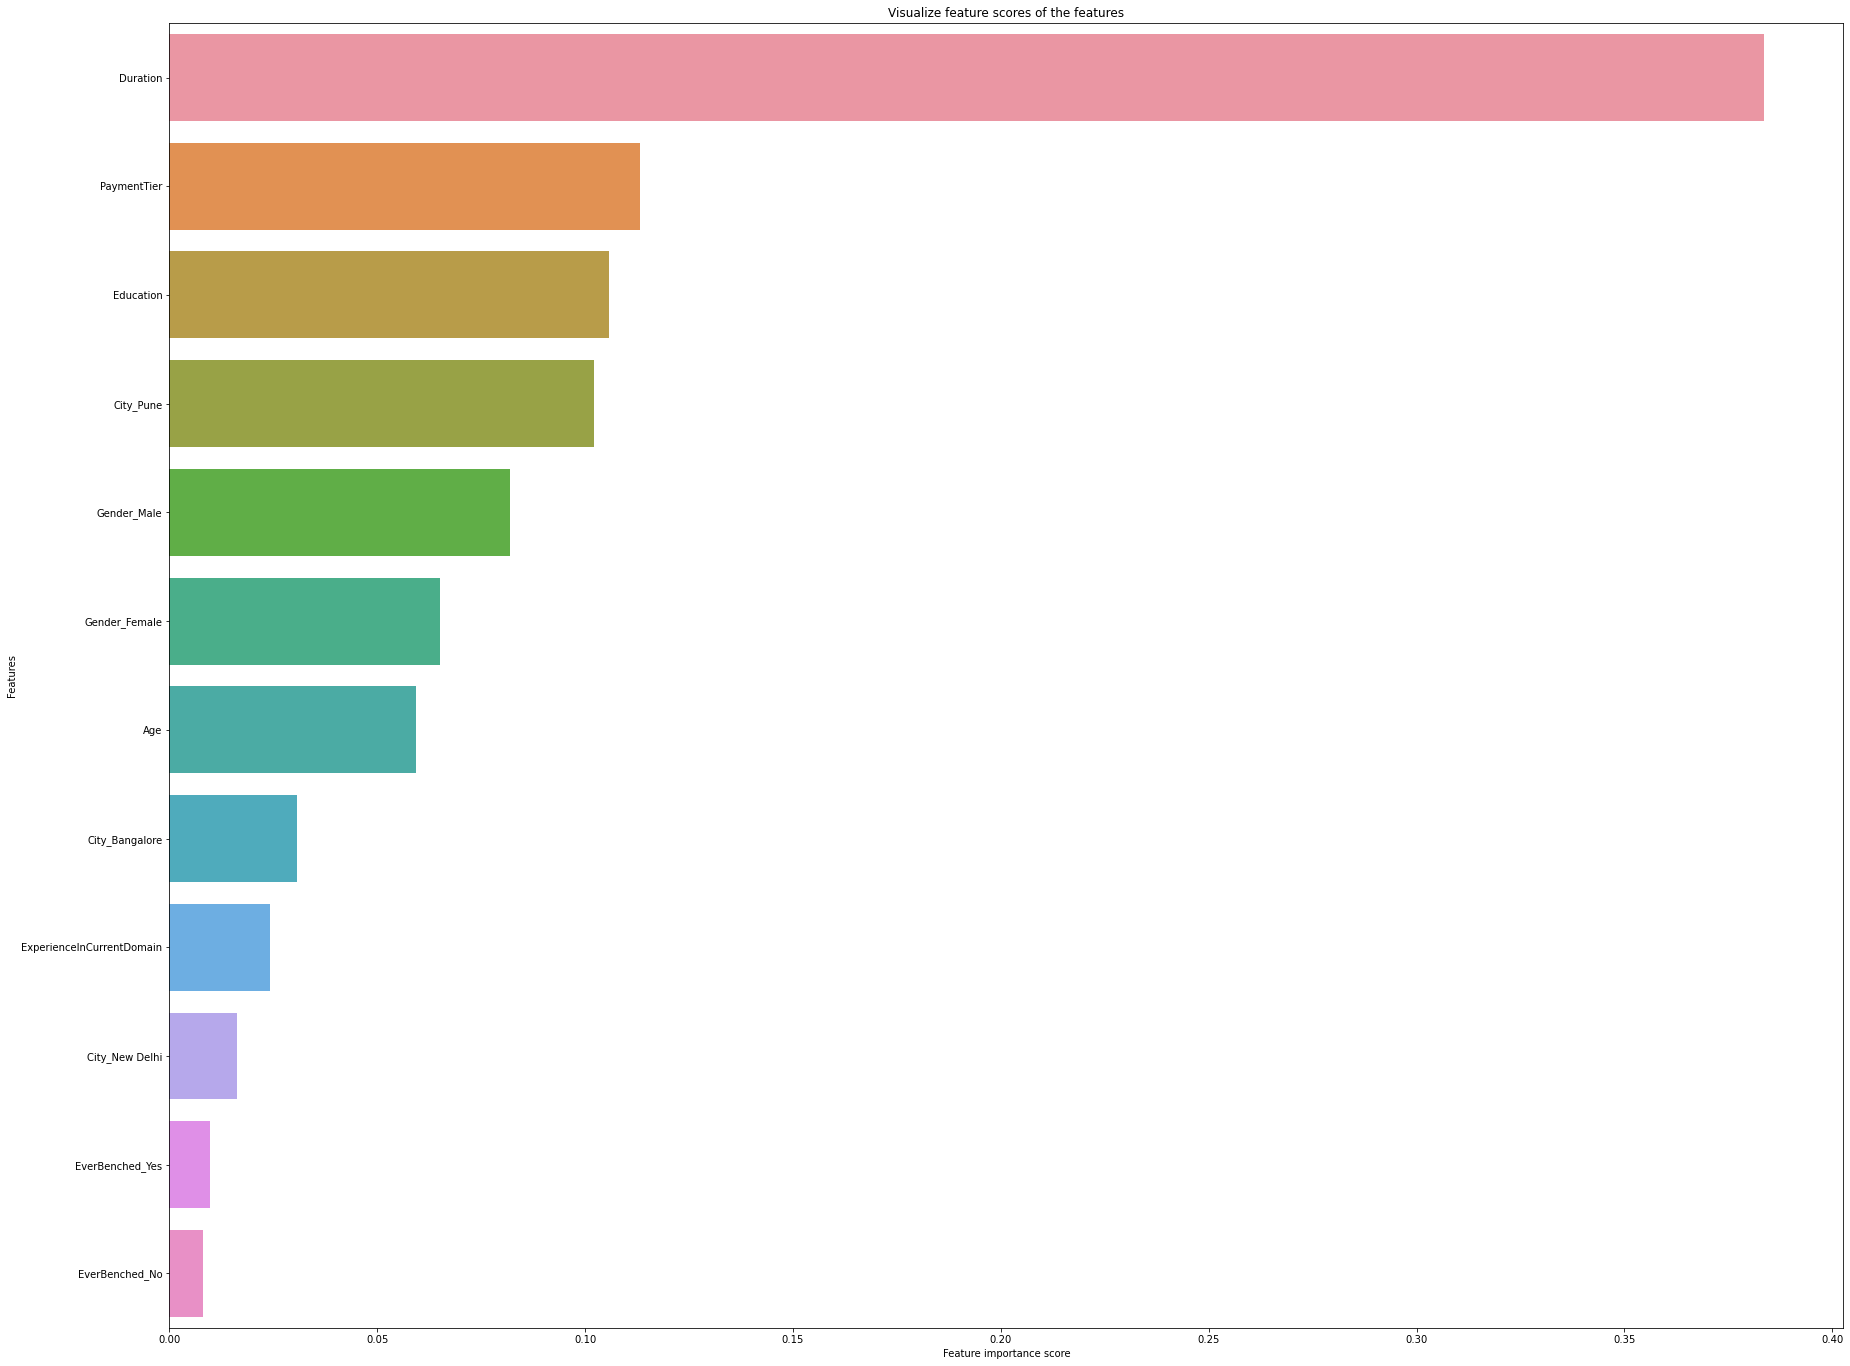

In [267]:
# Creating a seaborn bar plot
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores_all, y=feature_scores_all.index, data = x_all[[]])
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores_all.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

### --> It seems Duration, PaymentTier,  Education  and City are a good candidate for a simplified model

### *Data with Duration, PaymentTier, Education and City as predictor variables 

In [268]:
#---Training set---

x = employee_train[['Duration', 'PaymentTier', 'Gender', 'City']]
x = pd.get_dummies(x)
y = employee_train[['LeaveOrNot']]
x_names = ['Duration', 'PaymentTier', 'Gender', 'City']
x_names = x.columns.values
y_names = ["No", "Yes"]

#---Test set---

x_test = employee_test[['Duration', 'PaymentTier', 'Gender', 'City']]
x_test = pd.get_dummies(x_test)
y_test = employee_test[['LeaveOrNot']]
x_test_names = x_test.columns
y_test_names = ["No", "Yes"]

x.head(2)

,Duration,PaymentTier,Gender_Female,Gender_Male,City_Bangalore,City_New Delhi,City_Pune
2040,3,3,0,1,0,0,1
1872,4,3,0,1,1,0,0


In [269]:
#Change response variable to one-dimension array 
rfy = np.ravel(y)

In [270]:
#The n_estimators= 100, criterion  = "gini" id default (don't have to specufy)--
#--set max_depth to limit the depth of the tree, or limit branches
#--Set random_state for reproducible results
rf = RandomForestClassifier(n_estimators = 100, \
                              criterion = "gini", max_depth=5, random_state = 42).fit(x,rfy)

y_train_pred = rf.predict(x)
y_train_pred 

array([0, 0, 0, ..., 0, 0, 0])

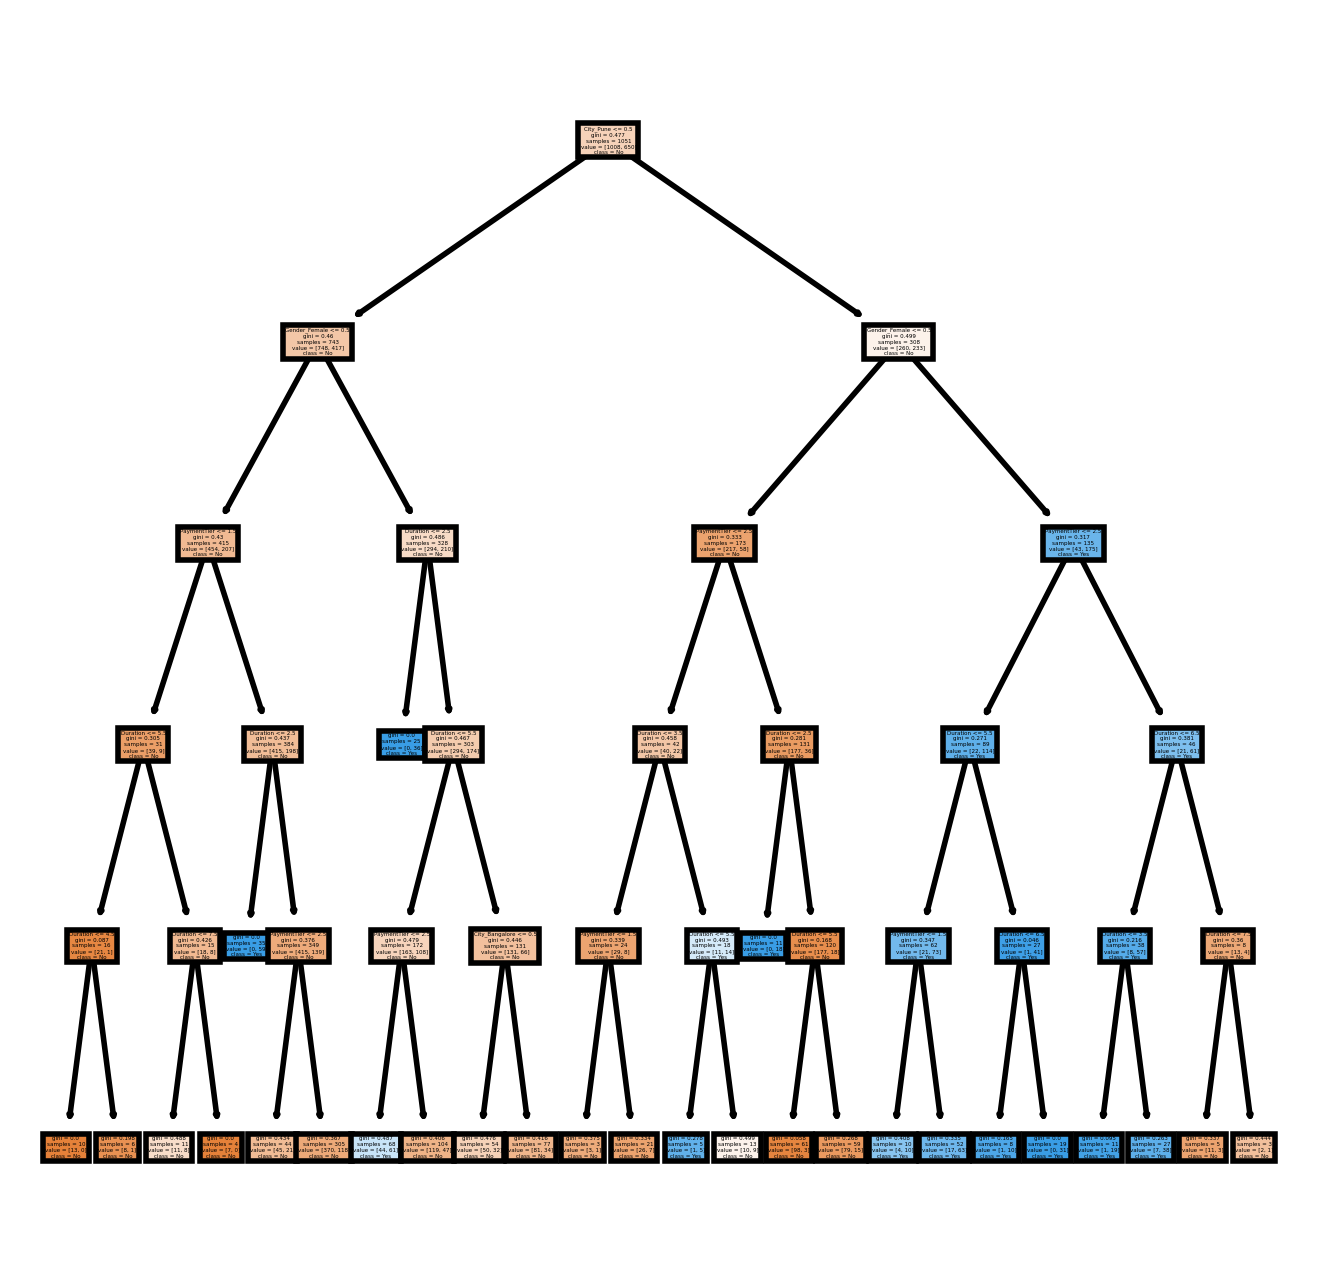

In [271]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=400)
#use .estimator[] to specify individual tree 
tree.plot_tree(rf.estimators_[0],
               feature_names = x.columns.values, 
               class_names=y_names,
               filled = True);
fig.savefig('rf_individualtree.png')

In [283]:
#Make prediction
y_pred2 = rf.predict(x_test)

#count number of predict for each class
unique, counts = np.unique(y_pred2, return_counts=True)
dict(zip(unique, counts))

{0: 808, 1: 298}

In [284]:
#calculate the Evaluation measure based on the contingency above
TN, FP, FN, TP = confusion_matrix(y_test, y_pred2).ravel()
Specificity2 = TN / (TN+FP)
Accuracy2 = metrics.accuracy_score(y_test, y_pred2)
Precision2 = metrics.precision_score(y_test, y_pred2)
Recall2 = metrics.recall_score(y_test, y_pred2)
F1_Score2 = metrics.f1_score(y_test, y_pred2)
ErrorRate2 = 1-Accuracy2

print("Accuracy:", Acuracy2)
print("Precision:", Precision2)
print("Recall:", Recall2 )

Accuracy: 0.7703435804701627
Precision: 0.8389261744966443
Recall: 0.5482456140350878


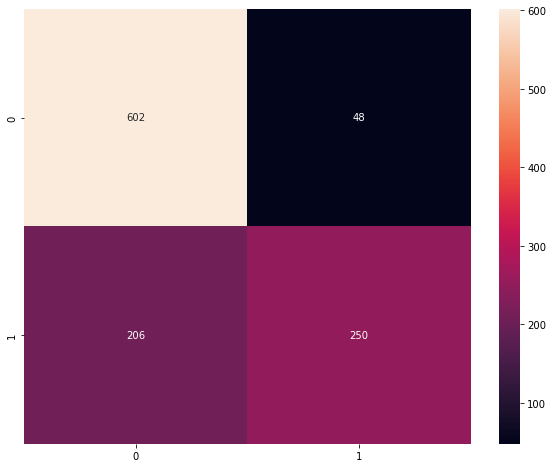

In [285]:
cm2 = confusion_matrix(y_test, y_pred2)
f = sns.heatmap(cm2, annot=True, fmt='d')

## Try K-nearest Neighbors

In [292]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import seaborn as sns

In [370]:
n_neighbors = 3
knn = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knn.fit(x, y)
y_pred3 = knn.predict(x_test)
unique, counts = np.unique(y_pred3, return_counts=True)
dict(zip(unique, counts))

{0: 690, 1: 416}

In [372]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred3).ravel()
Specificity3 = TN / (TN+FP)
Accuracy3 = metrics.accuracy_score(y_test, y_pred3)
Precision3 = metrics.precision_score(y_test, y_pred3)
Recall3 = metrics.recall_score(y_test, y_pred3)
F1_Score3 = metrics.f1_score(y_test, y_pred3)
ErrorRate3 = 1-Accuracy3

print("Accuracy:", Accuracy3)
print("Precision:", Precision3)
print("Recall:", Recall3 )

Accuracy: 0.7179023508137432
Precision: 0.6730769230769231
Recall: 0.6140350877192983


#### Find optimal K value fro K-nearest Neighbor - Elbow Method

In [318]:
#feature Scaling  
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [375]:
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(x, y)
 pred_i = knn.predict(x_test)
 pred_i= pred_i.reshape(1106,1)# To make length consistent
 error_rate.append(np.mean(pred_i != y_test))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

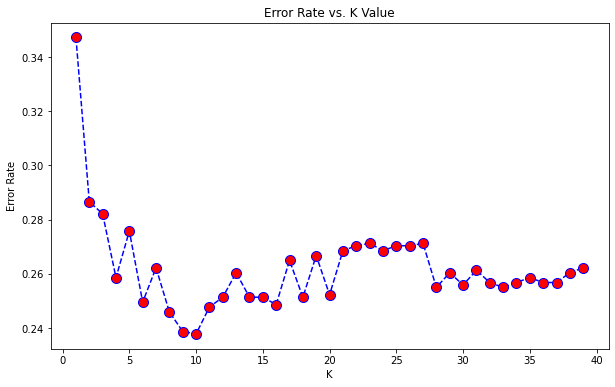

In [376]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",req_k_value)

### --> it seems like optimal K value is around 10 which give the highest accuracy and precision. Though, since we care more about sensitivity and K = 3 give the highest sensitivity

## Copy of C5 run for comparing models using Precision-Recall Curves 

In [289]:
#Run C5.0 using entropy criterion
C5 = DecisionTreeClassifier(criterion = "gini", \
                                max_leaf_nodes = 10, \
                                min_samples_leaf= 75).fit(x,y)
export_graphviz (C5, out_file = 'C5_1.dot')

#make prediction
y_pred1 = C5.predict(x_test)

#calculate the Evaluation measure based on the contingency above

TN, FP, FN, TP = confusion_matrix(y_test, y_pred1).ravel()

Specificity1 = TN / (TN+FP)
Accuracy1 = metrics.accuracy_score(y_test, y_pred1)
Precision1 = metrics.precision_score(y_test, y_pred1)
Recall1 = metrics.recall_score(y_test, y_pred1)
F1_Score1 = metrics.f1_score(y_test, y_pred1)
ErrorRate1 = 1-Accuracy1

print("Accuracy:",Accuracy1)
print("Precision:",Precision1)
print("Recall:", Recall1  )
print("Specificity:", Specificity1)
print("F1_Score:",F1_Score1)


Accuracy: 0.7115732368896925
Precision: 0.7455197132616488
Recall: 0.45614035087719296
Specificity: 0.8907692307692308
F1_Score: 0.5659863945578232


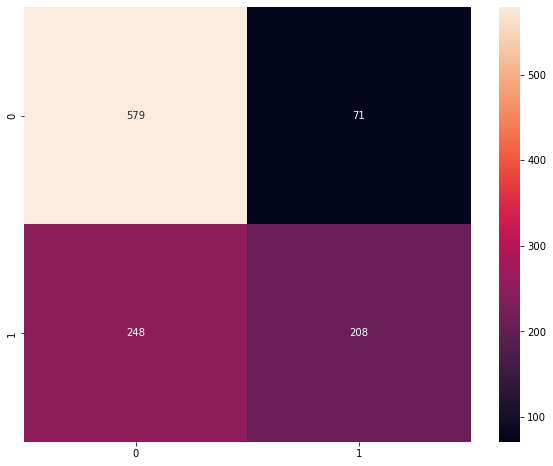

In [290]:
cm = confusion_matrix(y_test, y_pred1)

f = sns.heatmap(cm, annot=True, fmt='d')

### ROC Curves

In [280]:
from sklearn.metrics import roc_curve

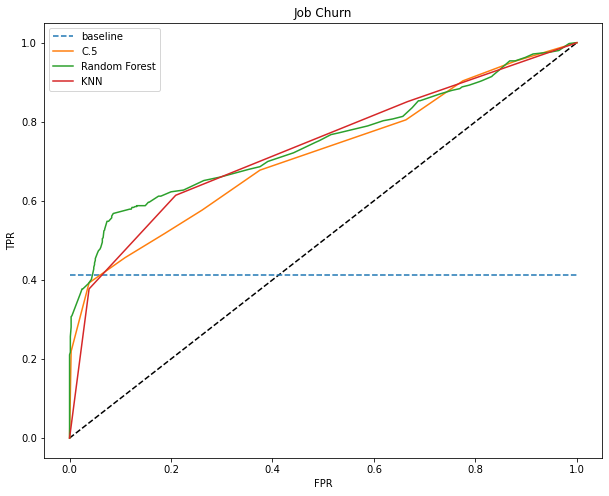

In [374]:
y_pred_prob1 = C5.predict_proba(x_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

y_pred_prob2 = rf.predict_proba(x_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

y_pred_prob3 = knn.predict_proba(x_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

baseline = y_test[y_test==1].value_counts()/len(y_test)
plt.plot([0,1],[0,1], 'k--')
plt.plot([baseline, baseline], linestyle='--', label='baseline')
plt.plot(fpr1, tpr1, label= "C.5")
plt.plot(fpr2, tpr2, label= "Random Forest")
plt.plot(fpr3, tpr3, label= "KNN")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Job Churn')
plt.show()

### Comparing Model Performances

In [373]:
# create the Model Evaluation Table
d = {'Evaluation Measure': ['Acuracy', 'Error Rate', 'Recall', 'Specificity', 
                        'Precision', 'F1_Score'],
     'C.5': [Accuracy1, ErrorRate1, Recall1, Specificity1, 
                     Precision1, F1_Score1],
     'Random Forest': [Accuracy2, ErrorRate2, Recall2, Specificity2, 
                     Precision2, F1_Score2],
     'KNN': [Accuracy3, ErrorRate3, Recall3, Specificity3, 
                     Precision3, F1_Score3],
    }
df = pd.DataFrame(data = d)
df

,Evaluation Measure,C.5,Random Forest,KNN
0,Acuracy,0.711573,0.770344,0.717902
1,Error Rate,0.288427,0.229656,0.282098
2,Recall,0.456140,0.548246,0.614035
3,Specificity,0.890769,0.926154,0.790769
4,Precision,0.745520,0.838926,0.673077
5,F1_Score,0.565986,0.663130,0.642202
